In [1]:
import torch
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
import yaml
import os
import cv2

In [2]:
task = ["openable", "cuttable", "pourable", "containable", "supportable", "holdable"]

In [3]:
cmap = mcolors.ListedColormap(['black', 'red', 'white'])
norm = mcolors.Normalize(0, 255)

def plot(input=None, weak_target=None, target=None, output=None, mask=None):
    if input is not None:
        plt.figure(figsize=(6, 6))
        plt.imshow(input)
        plt.title("Input", fontsize=20)
        plt.show()

    if weak_target is not None:
        plt.figure(figsize=(30, 4))
        num_classes = len(weak_target)
        for i in range(num_classes):
            plt.subplot(1, num_classes, i+1)
            img = np.array(weak_target[i])
            img[img==255] = 128
            img[img==1] = 255
            plt.imshow(img, cmap=cmap, norm=norm)
            plt.title("Weak: " + task[i], fontsize=20)
        plt.show()

    if target is not None:
        plt.figure(figsize=(30, 4))
        num_classes = len(target)
        for i in range(num_classes):
            plt.subplot(1, num_classes, i+1)
            img = np.array(target[i])
            img[img==255] = 128
            img[img==1] = 255
            plt.imshow(img, cmap=cmap, norm=norm)
            plt.title("Target: " + task[i], fontsize=20)
        plt.show()
    
    if output is not None:
        plt.figure(figsize=(30, 4))
        num_classes = len(output)
        for i in range(num_classes):
            plt.subplot(1, num_classes, i+1)
            img = np.array(output[i])
            img[img==1] = 255
            plt.imshow(img, cmap=cmap, norm=norm)
            plt.title("Output: " + task[i], fontsize=20)
        plt.show()

    if mask is not None:
        plt.figure(figsize=(6, 6))
        img = np.array(mask)
        img[img==1] = 255
        plt.imshow(img, cmap=cmap, norm=norm)
        plt.title("Mask", fontsize=20)
        plt.show()

In [4]:
def image_draw(image, keypoint):
    new_image = Image.fromarray(image.copy())
    draw = ImageDraw.Draw(new_image)
    stroke_width = 10
    for _, joints in keypoint:
        if len(joints) > 1:
            draw.line(np.array(joints).flatten(), 1, 10, joint="curve")
        for i in range(len(joints)):
            draw.ellipse(
                (
                    joints[i][0] - stroke_width / 2,
                    joints[i][1] - stroke_width / 2,
                    joints[i][0] + stroke_width / 2,
                    joints[i][1] + stroke_width / 2,
                ),
                1,
            )

    return new_image

In [6]:
from model import CerberusAffordanceModel

model = CerberusAffordanceModel(len(task))

resume_time = "point"
resume_level = "model_best" # model_best, checkpoint_latest
resume_path = f"output/{resume_time}/model/{resume_level}.pth"

ckpt = torch.load(resume_path)

model.load_state_dict(
    {
        k.replace("module.", ""): v
        for k, v in ckpt["state_dict"].items()
    }
)
model.eval()

print(f"Best Score: {ckpt['best_score']}")

Best Score: 26.703381079494257


In [5]:
keypoint_path = "../dataset/cad120/object/train_affordance_keypoint.yaml"

with open(keypoint_path, "r") as fb:
    keypoint_dict = yaml.safe_load(fb)

In [17]:
import transform as TF

mean = [132.47758920907586, 106.32022472065732, 111.5704799224029]
std = [67.45043019809088, 70.23484330785524, 72.19806953380163]

train_tf = TF.Compose(
    [
        TF.RandomScaledTiltedWarpedPIL(
            random_crop_size=(320, 320),
            random_scale_max=1.0,
            random_scale_min=1.0,
            random_tilt_max_deg=0,
            random_wiggle_max_ratio=0,
            random_horizon_reflect=True,
            center_offset_instead_of_random=False,
            ignore_index=255,
        ),
        TF.ConvertPointLabel(len(task), 0, ignore_index=255),
        TF.PILToTensor(),
        TF.ImageNormalizeTensor(mean=mean, std=std),
    ]
)
val_tf = TF.Compose([
    TF.ResizePIL((320, 320)),
    TF.PILToTensor(),
        TF.ImageNormalizeTensor(mean=mean, std=std),
])


In [14]:
file_name = "10058_1"
input_path = f"../dataset/cad120/object/affordance/images/{file_name}.png"
target_path = f"../dataset/cad120/object/affordance/labels/{file_name}.pkl"

data = dict()

data["file_name"] = os.path.basename(input_path).split(".")[0]
data["image"] = Image.open(input_path)

with open(target_path, "rb") as fb:
    dense_label = pickle.load(fb)
    data["dense_label"] = [Image.fromarray(dense_label[:, :, i]) for i in range(dense_label.shape[2])]

# data["point_label"] = keypoint_dict[data["file_name"]]

data["validity"] = Image.new("L", data["image"].size, color=1)

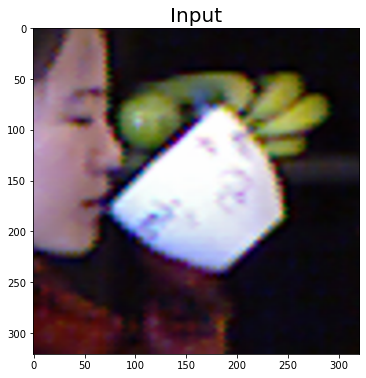

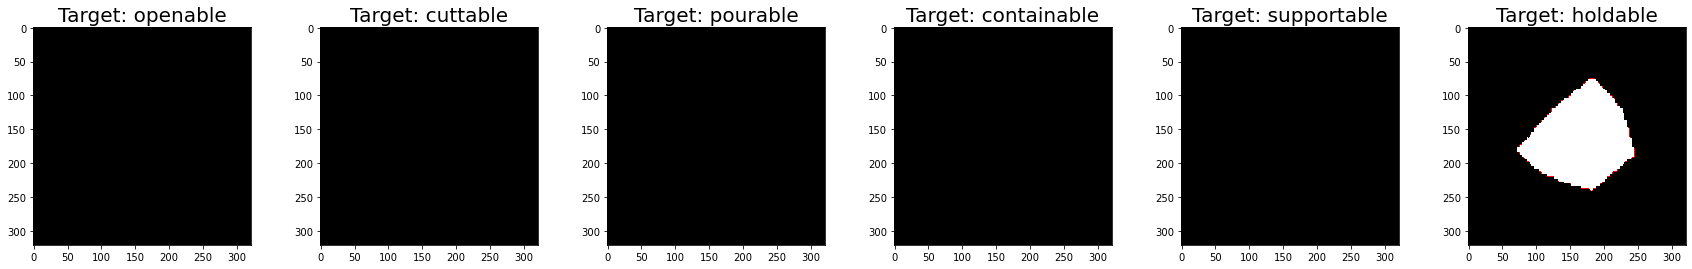

In [15]:
plot(input=data["image"], target=data["dense_label"], weak_target=data["weak_label"] if "weak_label" in data else None)

In [16]:
new_data = train_tf(data.copy())
# new_data = val_tf(data.copy())

NameError: name 'val_tf' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


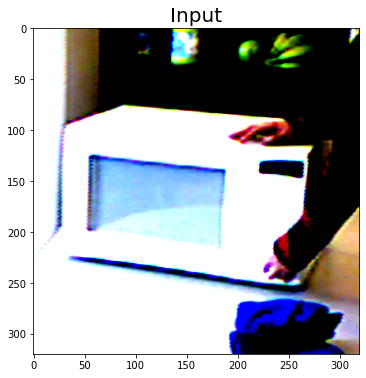

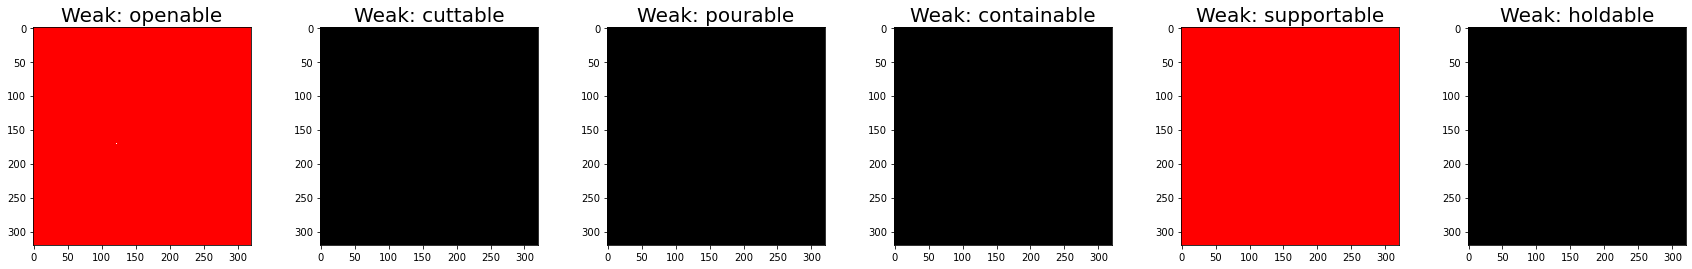

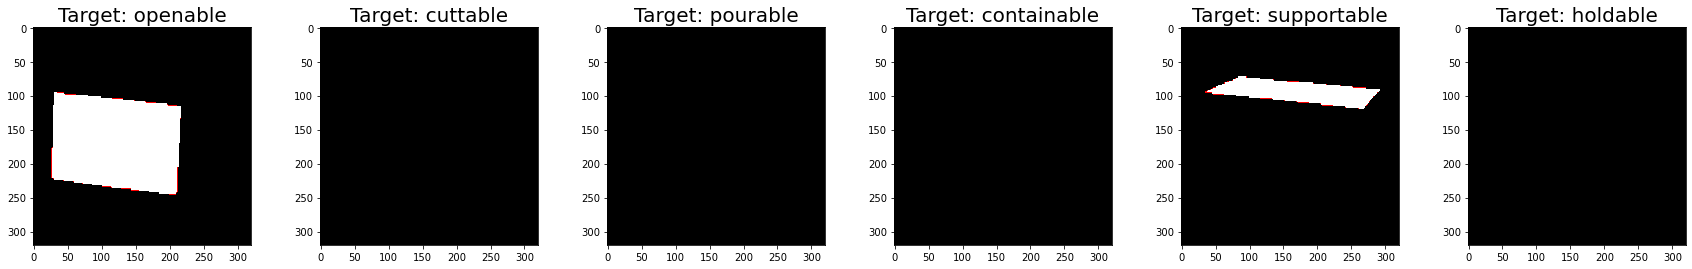

openable: 1
cuttable: 0
pourable: 0
containable: 0
supportable: 1
holdable: 0


In [12]:
image = new_data["image"].permute(1, 2, 0).contiguous().numpy()
weak_label = new_data["weak_label"]

plot(input=image, weak_target=weak_label, target=new_data["dense_label"])
for i in range(len(task)):
    print(f"{task[i]}: {(weak_label[i] == 1).sum()}")

In [16]:
with torch.no_grad():
    output = model(new_data["image"].unsqueeze(0))

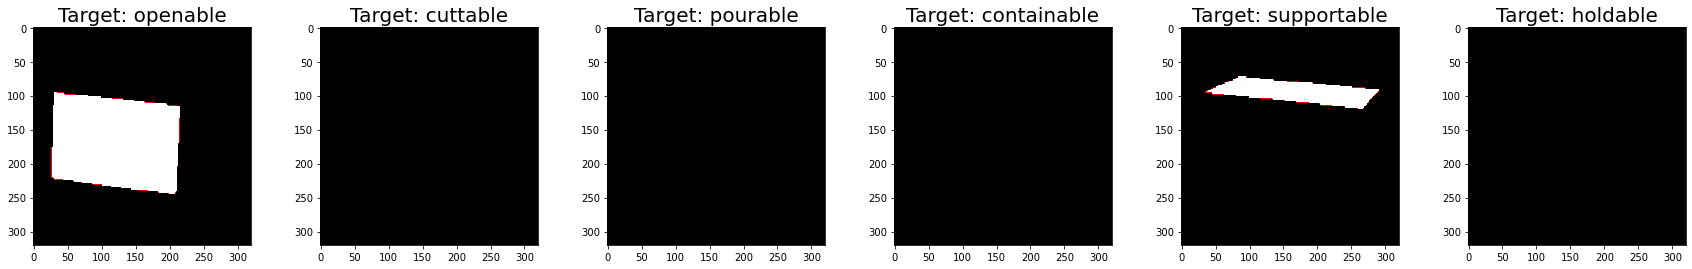

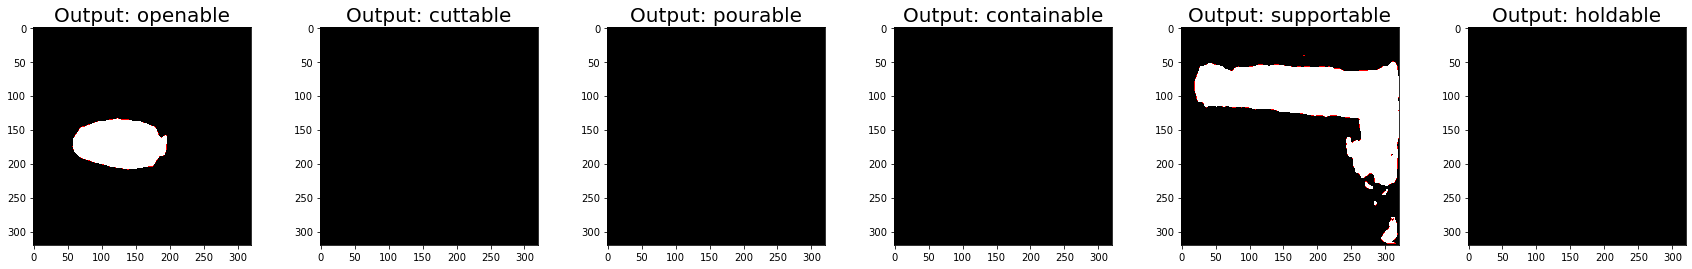

In [25]:
validity = new_data["validity"].squeeze(0)
# pred = [output[i].argmax(1).squeeze(0) * validity for i in range(len(task))]
pred = [(output[i].sigmoid().squeeze(0).squeeze(0) > 0.94).int() * validity for i in range(len(task))]

plot(weak_target=new_data["weak_label"], target=new_data["dense_label"], output=pred, mask=validity)
# plot(target=new_data["dense_label"], output=pred)